# Growth of File Sizes

For this test, we have generated `.h5` data files using the `generate_data_deterministic.py` script from the repository, using the standard options ([see details here](#standard))

## Setup

The path to the generated test files is

In [1]:
path = "/home/melissa/projects/versioned-hdf5/analysis" # change this as necessary

In [2]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import pickle
import numpy as np
import matplotlib.pyplot as plt
import h5py
from versioned_hdf5 import VersionedHDF5File
from generate_data_deterministic import TestVersionedDatasetPerformance

In [3]:
# auxiliary code to format file sizes 
def format_size(size):
    suffixes = ['B', 'KB', 'MB', 'GB']
    i = 0
    while size >= 1024 and i < len(suffixes)-1:
        size = size/1024
        i += 1
    return f"{size:.2f} {suffixes[i]}"

# Test 1: Large fraction changes (sparse)

In [4]:
testname = "test_large_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

```python
num_transactions_1 = [50, 100, 500, 1000, 5000, 7500, 10000, 12000, 15000, 20000, 30000]
```

Modify `num_transactions_1` for the desired tests. Please keep in mind that file sizes can become very large for large numbers of transactions (above 5000 transactions).

In [5]:
num_transactions_1 = [50, 100, 500]

In [6]:
tests = []
for t in num_transactions_1:
    filename = os.path.join(path, f"{testname}_{t}.h5")
    try:
        h5pyfile = h5py.File(filename, 'r')
    except:
        print(f"File with {t} transactions not available. Creating new file ")
        TestVersionedDatasetPerformance().test_large_fraction_changes_sparse(t)
        h5pyfile = h5py.File(filename, 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))

File with 50 transactions not available. Creating new file 
File with 100 transactions not available. Creating new file 
File with 500 transactions not available. Creating new file 


## Number of versions v. File size

We'll start by analyzing how the `.h5` file sizes grow as the number of versions grows. 

In [7]:
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

Note that the array size also grows as the number of versions grows, since each transaction is changing the original arrays by adding, deleting and changing values in the original arrays. In order to compute a (naive) theoretical lower bound on the file size, we'll compute how much space each version should take. Keep in mind there is redundant data as some of it is not changed during the staging of a new version but it is still being stored. In this example, we start with three arrays with 5000 elements (2 integer arrays and one float), and in the end we have the following array sizes:

In [8]:
for test in tests:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

Maximum array size for file with 50: 5500
Maximum array size for file with 100: 6000
Maximum array size for file with 500: 10000


In [9]:
test_large_fraction_changes_sparse = []
for test in tests:
    test_large_fraction_changes_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 'theoretical_sizes']))

Let's show the size information in a graph:

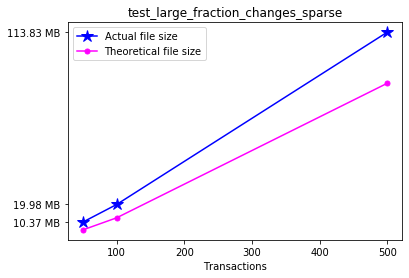

In [10]:
filesizes_1 = np.array([test['size'] for test in test_large_fraction_changes_sparse])
sizelabels_1 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse])
tsizes_1 = np.array([test['theoretical_sizes'] for test in test_large_fraction_changes_sparse])

fig_large_fraction_changes = plt.figure()
plt.plot(num_transactions_1, filesizes_1, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_1, tsizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_1, sizelabels_1)
plt.show()

Just for the sake of reproducibility, we have pickled the filesizes for larger tests so we can recover them later, since large files give us different behaviour:

In [11]:
with open("test_large_fraction_changes_sparse_versions.pickle", "rb") as pickle_in:
    test_large_fraction_changes_sparse = pickle.load(pickle_in)

Plotting these larger file sizes, we get the following graph:

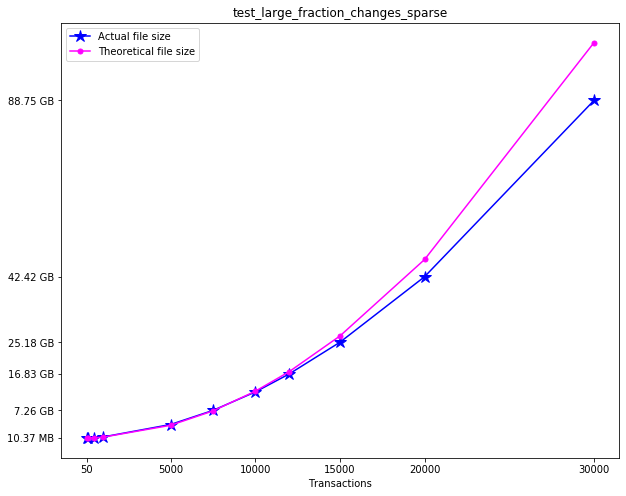

In [12]:
num_transactions_1 = [50, 100, 500, 1000, 5000, 7500, 10000, 12000, 15000, 20000, 30000]
filesizes_1 = np.array([test['size'] for test in test_large_fraction_changes_sparse])
sizelabels_1 = np.array([test['size_label'] for test in test_large_fraction_changes_sparse])
tsizes_1 = np.array([test['theoretical_sizes'] for test in test_large_fraction_changes_sparse])

fig_large_fraction_changes_log = plt.figure(figsize=(10,8))
plt.plot(num_transactions_1, filesizes_1, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_1, tsizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xticks([50, 5000, 10000, 15000, 20000, 30000])
plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_1[[0, 5, 7, 8, 9, 10]], sizelabels_1[[0, 5, 7, 8, 9, 10]])
plt.show()

Note that between 7500 transactions and 10000 transactions, there is a cross between the curves and the actual filesizes are **smaller** than the expected file size.

Changing the view to a logarithmic scale, we have this:

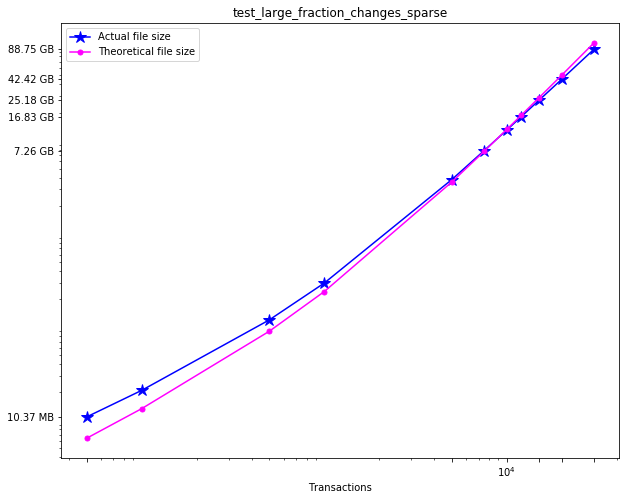

In [13]:
fig_large_fraction_changes_log = plt.figure(figsize=(10,8))
plt.loglog(num_transactions_1, filesizes_1, '*-', ms=12, color='blue', label="Actual file size")
plt.loglog(num_transactions_1, tsizes_1, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xticks([50, 5000, 10000, 15000, 20000, 30000])
plt.xlabel("Transactions")
plt.title("test_large_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_1[[0, 5, 7, 8, 9, 10]], sizelabels_1[[0, 5, 7, 8, 9, 10]])
plt.show()

### Finishing up

In [14]:
for test in tests:
    test['h5pyfile'].close()

# Test 2: Mostly appends (sparse)

In [15]:
testname = "test_mostly_appends_sparse"

For this case, we have tested the following number of transactions:

```python
num_transactions_2 = [50, 100, 500, 1000, 2000, 5000, 10000]
```

Change `num_transactions_2` as desired:

In [16]:
num_transactions_2 = [50, 100, 500]

In [25]:
# Setting up dictionary with test info
tests = []
for t in num_transactions_2:
    filename = os.path.join(path, f"{testname}_{t}.h5")
    try:
        h5pyfile = h5py.File(filename, 'r')
    except:
        print(f"File with {t} transactions not available. Creating new file ")
        TestVersionedDatasetPerformance().test_mostly_appends_sparse(t)
        h5pyfile = h5py.File(filename, 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))

# Computing file sizes
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

In [26]:
for test in tests:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

Maximum array size for file with 50: 5500
Maximum array size for file with 100: 6000
Maximum array size for file with 500: 10000


In [27]:
test_mostly_appends_sparse = []
for test in tests:
    test_mostly_appends_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 'theoretical_sizes']))

In the graph

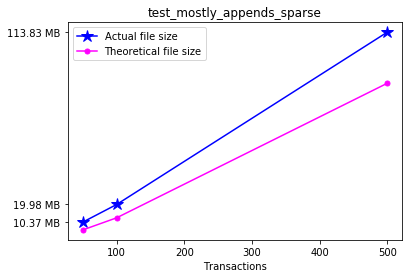

In [28]:
filesizes_2 = np.array([test['size'] for test in test_mostly_appends_sparse])
sizelabels_2 = np.array([test['size_label'] for test in test_mostly_appends_sparse])
tsizes_2 = np.array([test['theoretical_sizes'] for test in test_mostly_appends_sparse])

fig_mostly_appends_sparse = plt.figure()
plt.plot(num_transactions_2, filesizes_2, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_2, tsizes_2, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xlabel("Transactions")
plt.title("test_mostly_appends_sparse")
plt.legend()
plt.yticks(filesizes_2, sizelabels_2)
plt.show()

Again, for the sake of reproducibility, we will pickle the filesizes for larger tests so we can recover them later, since large files give us different behaviour. This is still being developed. Meanwhile, we show a static version of the preliminary results.

## Test 2: Mostly Appends (Sparse)

![Test 2: Mostly Appends (Sparse)](test_mostly_appends_sparse_versions.png)

In [29]:
for test in tests:
    test['h5pyfile'].close()

# Test 3: Small fraction changes (sparse)

In [30]:
testname = "test_small_fraction_changes_sparse"

We have tested the following numbers of versions (or transactions):

```python
num_transactions_3 = [50, 100, 500, 1000, 5000, 7500, 10000, 12000, 15000, 20000, 30000]
```

Once more, in order to run tests locally, adjust `num_transactions_3` as desired:

In [31]:
num_transactions_3 = [50, 100, 500]

In [32]:
# Setting up dictionary with test info
tests = []
for t in num_transactions_3:
    filename = os.path.join(path, f"{testname}_{t}.h5")
    try:
        h5pyfile = h5py.File(filename, 'r')
    except:
        print(f"File with {t} transactions not available. Creating new file ")
        TestVersionedDatasetPerformance().test_small_fraction_changes_sparse(t)
        h5pyfile = h5py.File(filename, 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))
    
# Computing file sizes
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

In [33]:
for test in tests:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

Maximum array size for file with 50: 5500
Maximum array size for file with 100: 6000
Maximum array size for file with 500: 10000


In [34]:
test_small_fraction_changes_sparse = []
for test in tests:
    test_small_fraction_changes_sparse.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 'theoretical_sizes']))

In the graph:

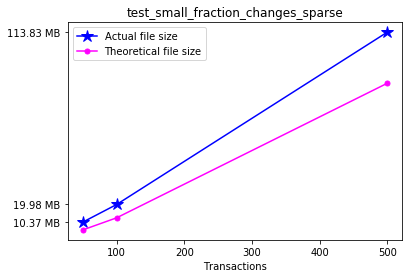

In [35]:
filesizes_3 = np.array([test['size'] for test in test_small_fraction_changes_sparse])
sizelabels_3 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse])
tsizes_3 = np.array([test['theoretical_sizes'] for test in test_small_fraction_changes_sparse])

fig_small_fraction_changes = plt.figure()
plt.plot(num_transactions_3, filesizes_3, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_3, tsizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_3, sizelabels_3)
plt.show()

We have pickled a larger test set for observing the files behaviour.

In [36]:
with open("test_small_fraction_changes_sparse_versions.pickle", "rb") as pickle_in:
    test_small_fraction_changes_sparse = pickle.load(pickle_in)

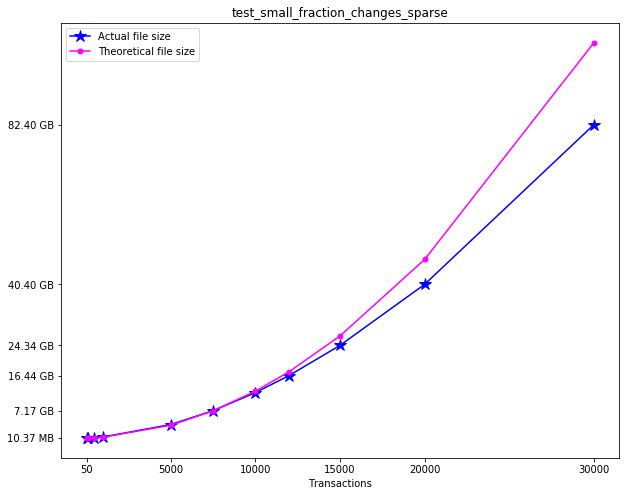

In [37]:
num_transactions_3 = [50, 100, 500, 1000, 5000, 7500, 10000, 12000, 15000, 20000, 30000]
filesizes_3 = np.array([test['size'] for test in test_small_fraction_changes_sparse])
sizelabels_3 = np.array([test['size_label'] for test in test_small_fraction_changes_sparse])
tsizes_3 = np.array([test['theoretical_sizes'] for test in test_small_fraction_changes_sparse])

fig_small_fraction_changes = plt.figure(figsize=(10,8))
plt.plot(num_transactions_3, filesizes_3, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_3, tsizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xticks([50, 5000, 10000, 15000, 20000, 30000])
plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_3[[0, 5, 7, 8, 9, 10]], sizelabels_3[[0, 5, 7, 8, 9, 10]])
plt.show()

Changing to a logarithmic scale, we have the following:

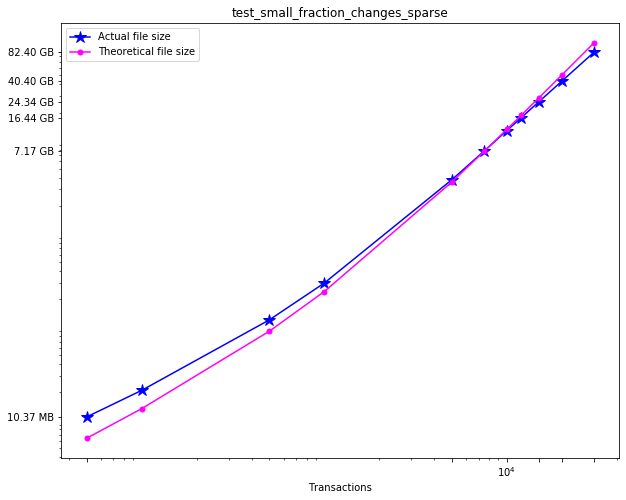

In [38]:
fig_small_fraction_changes = plt.figure(figsize=(10,8))
plt.loglog(num_transactions_3, filesizes_3, '*-', ms=12, color='blue', label="Actual file size")
plt.loglog(num_transactions_3, tsizes_3, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xticks([50, 5000, 10000, 15000, 20000, 30000])
plt.xlabel("Transactions")
plt.title("test_small_fraction_changes_sparse")
plt.legend()
plt.yticks(filesizes_3[[0, 5, 7, 8, 9, 10]], sizelabels_3[[0, 5, 7, 8, 9, 10]])
plt.show()

In [39]:
for test in tests:
    test['h5pyfile'].close()

# Test 4: Mostly appends (dense)

In [40]:
testname = "test_mostly_appends_dense"

For this case, we have tested the following number of transactions:

```python
num_transactions_4 = [50, 100, 500, 1000, 2000, 5000, 10000]
```

Change `num_transactions_4` as desired:

In [41]:
num_transactions_4 = [50, 100, 500]

In [42]:
# Setting up dictionary with test info
tests = []
for t in num_transactions_4:
    filename = os.path.join(path, f"{testname}_{t}.h5")
    try:
        h5pyfile = h5py.File(filename, 'r')
    except:
        print(f"File with {t} transactions not available. Creating new file ")
        TestVersionedDatasetPerformance().test_mostly_appends_dense(t)
        h5pyfile = h5py.File(filename, 'r')
    data = VersionedHDF5File(h5pyfile)
    tests.append(dict(num_transactions=t, filename=filename, h5pyfile=h5pyfile, data=data))

# Computing file sizes
for test in tests:
    test['size'] = os.path.getsize(test['filename'])
    test['size_label'] = format_size(test['size'])

File with 50 transactions not available. Creating new file 
File with 100 transactions not available. Creating new file 
File with 500 transactions not available. Creating new file 


Next, we compute the theoretical file sizes. 

In [43]:
for test in tests:
    lengths = []
    total_size = 0
    for vname in test['data']._versions:
        if vname != '__first_version__':
            version = test['data'][vname]
            group_key = list(version.keys())[0]
            lengths.append(len(version[group_key]['val']))
            total_size += len(version[group_key]['val'])
    test['theoretical_sizes'] = 24*total_size
    print(f"Maximum array size for file with {test['num_transactions']}: {max(lengths)}")

Maximum array size for file with 50: 38400
Maximum array size for file with 100: 120900
Maximum array size for file with 500: 2400900


In [44]:
test_mostly_appends_dense = []
for test in tests:
    test_mostly_appends_dense.append(dict((k, test[k]) for k in ['num_transactions', 'filename', 'size', 'size_label', 'theoretical_sizes']))

In the graph:

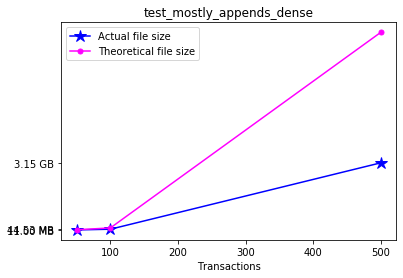

In [45]:
filesizes_4 = np.array([test['size'] for test in test_mostly_appends_dense])
sizelabels_4 = np.array([test['size_label'] for test in test_mostly_appends_dense])
tsizes_4 = np.array([test['theoretical_sizes'] for test in test_mostly_appends_dense])

fig_mostly_appends_dense = plt.figure()
plt.plot(num_transactions_4, filesizes_4, '*-', ms=12, color='blue', label="Actual file size")
plt.plot(num_transactions_4, tsizes_4, 'o-', ms=5, color='magenta', label="Theoretical file size")
plt.xlabel("Transactions")
plt.title("test_mostly_appends_dense")
plt.legend()
plt.yticks(filesizes_4, sizelabels_4)
plt.show()

Again, for the sake of reproducibility, we will pickle the filesizes for larger tests so we can recover them later, since large files give us different behaviour. This is still being developed. Meanwhile, we show a static version of the preliminary results.

## Test 2: Mostly Appends (Sparse)

![Test 2: Mostly Appends (Sparse)](test_mostly_appends_sparse_versions.png)

In [46]:
for test in tests:
    test['h5pyfile'].close()

## Understanding each file

Each versioned HDF5 file contains 3 datasets per version:
- `key0`, an array of `int64`
- `key1`, an array of `int64`
- `val`, an array of `float64`
plus metadata about groups, datasets and versions.

This means that each file has  

```
nversions * 24 * arraysize + metadata
```
bytes of information.

<a id='standard'></a>
## Standard parameters

- `test_large_fraction_changes_sparse`: 
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `pct_inserts = 1`
    - `num_inserts = 10`
    - `pct_deletes = 1`
    - `num_deletes = 10`
    - `pct_changes = 90`
    - `num_changes = 1000`
- `test_small_fraction_changes_sparse`
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `pct_inserts = 1`
    - `num_inserts = 10`
    - `pct_deletes = 1`
    - `num_deletes = 10`
    - `pct_changes = 90`
    - `num_changes = 10`
- `test_mostly_appends_sparse`:
    - `num_rows_initial = 1000`
    - `num_rows_per_append = 1000`
    - `pct_inserts = 5`
    - `num_inserts = 10`
    - `pct_deletes = 1`
    - `num_deletes = 10`
    - `pct_changes = 5`
    - `num_changes = 10`  
- `test_mostly_appends_dense`
    - `num_rows_initial_0 = 30`
    - `num_rows_initial_1 = 30`
    - `num_rows_per_append_0 = 1`
    - `pct_inserts = 5`
    - `num_inserts_0 = 1`
    - `num_inserts_1 = 10`
    - `pct_deletes = 1`
    - `num_deletes_0 = 1`
    - `num_deletes_1 = 1`
    - `pct_changes = 5`
    - `num_changes = 10`